# Locally-Weighted Conformal Prediction for Regression

Conformal prediction for regression produces prediction bands with constant width when using the classical absolute conformity scores. This only makes sense when the spread of the residuals $Y-\hat{\mu}(X)$ does not vary, e.g., when the underlying ground-truth model is a linear regression with homoscedastic noise. In practice however, we may want to account for different prediction errors in different input regions.

This notebook shows how to implement *Locally-Weighted Conformal Prediction* from scratch, an approach that provides us with variable predictions bands. More precisely, we will fit a K-Nearest-Neighbors Regressor on the absolute residual errors $|Y-\hat{\mu}(X)|$ in order to obtain estimates for such errors on unseen data. We will then use *residual normalised scores* to conformalize these predictions, which leads to predictions bands with theoretical coverage guarantees on unseen data.

In short, we implement the [residual normalised scores](https://mapie.readthedocs.io/en/latest/theoretical_description_conformity_scores.html) from MAPIE from scratch and verify that both implementations actually produce the same results.

See Section 5.2 of the following paper for a precise description of the method:

*Lei, J., G’Sell, M., Rinaldo, A., Tibshirani, R. J., & Wasserman, L. (2018). Distribution-Free Predictive Inference for Regression. Journal of the American Statistical Association, 113(523), 1094–1111. Available from https://doi.org/10.1080/01621459.2017.1307116*

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

from util import regression_plot_with_uncertainty

Since we have to plot a lot of prediction bands, let us define a utility function for obtaining them from the predictive mean and the predictions of the absolute residuals.

In [3]:
def construct_prediction_bounds(mean_prediction, residual_prediction, quantiles):
    """
    A function that returns the lower and upper prediction bounds for every quantile in quantiles.
    """
    
    prediction_bounds = np.zeros((len(mean_prediction), 2, len(quantiles)))

    for i, q in enumerate(quantiles):
        prediction_bounds[:, :, i] = np.stack([
            mean_prediction - q * residual_prediction,
            mean_prediction + q * residual_prediction
        ], axis=1)

    return prediction_bounds

## Generate Toy Dataset with Heteroscedastic Noise

We sample data from a polynomial of degree 4 with heteroscedastic noise with standard deviation $x * \sigma$, where $x$ consists of equally spaced inputs in the range $[0, 1]$. $\sigma$ is a parameter for the initial noise standard deviation.

The following two data generation functions are derived from: <br />
https://mapie.readthedocs.io/en/latest/examples_regression/1-quickstart/plot_heteroscedastic_1d_data.html

In [4]:
def f(x):
    """Polynomial function used to generate one-dimensional data."""
    return np.array(5 * x + 5 * x ** 4 - 9 * x ** 2)

In [5]:
def generate_heteroscedastic_data(n_samples, sigma=0.1, random_state=42):
    """
    Generate one-dimensional data from a given function,
    where a given noise standard deviation increases linearly with x.
    """
    np.random.seed(random_state)
    X = np.linspace(0, 1, n_samples)[:, np.newaxis]
    y = f(X) + np.random.normal(0, sigma, (n_samples, 1)) * X
    y_gt = f(X)
    return X, y.ravel(), y_gt.ravel()

Let's generate the data for $\sigma=0.1$.

In [7]:
sigma = 0.1
X, y, y_gt = generate_heteroscedastic_data(n_samples=500, sigma=0.1, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Let's plot the ground-truth function and ground-truth 95% prediction intervals of the sampling distribution. We also add a couple of test points to the plot to verify that around 95% of them lie indeed inside the error bars.

In [8]:
print(f'Expected number of points outside the 95% error bars: {len(X_cal) * 0.05}')

Expected number of points outside the 95% error bars: 4.5


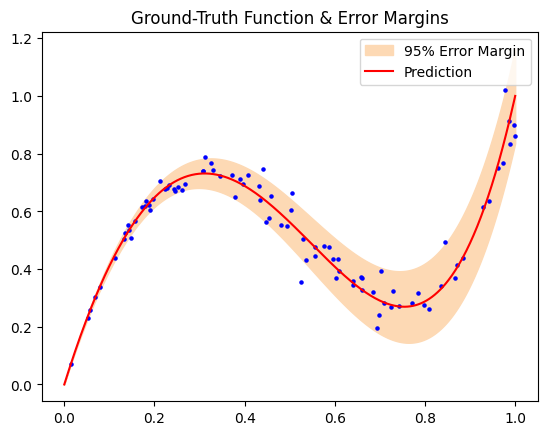

In [9]:
fig, ax = plt.subplots(1, 1)
# The 95th percentile of the standard normal distribution (for \sigma=1.0)
q95 = scipy.stats.norm.ppf(0.95)
# Since we sampled our data using y_gt + N(0, sigma) * X,
# the alpha=0.05 prediction bands should be [y_gt + sigma * q05 * X, y_gt + sigma * q95 * X]
prediction_bounds = construct_prediction_bounds(y_gt, (sigma * X).ravel(), [q95])
regression_plot_with_uncertainty(ax, X, y_gt, prediction_bounds, (X_cal, y_cal), labels=['95% Error Margin'])
ax.set_title('Ground-Truth Function & Error Margins')
plt.show()

The plot confirms that the ground-truth predictive bands indeed capture around 95% of the calibration points that we plotted (around 5 points lie outside).

## Residual Normalised Scores

We will now start implementing *residual normalised scores* from scratch. See section 3 of the [MAPIE documentation](https://mapie.readthedocs.io/en/latest/theoretical_description_conformity_scores.html) for a reference.

For the residual error prediction model $\hat{\sigma}(X)$, we choose a K-Nearest-Neighbor predictor. Hence, we assume that prediction errors are similar in in the same input region.

In [10]:
# For the mean predictor, we choose polynomial features up to degree 4 since this is the degree of the ground-truth polynomial
mean_predictor = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=4)),
        ("linear", LinearRegression()),
    ]
)
mean_predictor.fit(X_train, y_train)
y_train_predict = mean_predictor.predict(X_train)

# Now we fit a KNeighborsRegressor on the absolute training errors for the residual error predictions
abs_errors = np.abs(y_train_predict - y_train)
residual_predictor = KNeighborsRegressor(n_neighbors=10, weights='uniform', algorithm='brute')
residual_predictor.fit(X_train, abs_errors)

KNeighborsRegressor(algorithm='brute', n_neighbors=10)

Without conformal predictions, our prediction bands look as follows. They are clearly tighter than the ground-truth ones from before! This is because we have not calibrated them to cover 95% of the points yet. However, we can see that high-noise regions have larger predictive bands already.

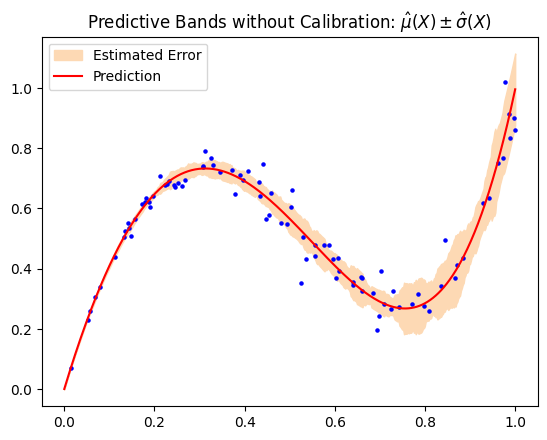

In [16]:
mean_prediction = mean_predictor.predict(X)
residual_prediction = residual_predictor.predict(X)
prediction_bounds = construct_prediction_bounds(mean_prediction, residual_prediction, [1.0])

fig, ax = plt.subplots(1, 1)
regression_plot_with_uncertainty(ax, X, mean_prediction, prediction_bounds, (X_cal, y_cal))
ax.set_title(r'Predictive Bands without Calibration: $\hat{\mu}(X) \pm \hat{\sigma}(X)$')
plt.show()

In order to correct our bands, we need to estimate their required upscaling. For this we need to first compute *residual normalised scores*:

$$\frac{| y - \hat{\mu}(X) |}{\hat{\sigma}(X)},$$

where $\hat{\mu}(X)$ are our mean predictions, $y$ the target variable, and $\hat{\sigma}(X)$ the error predictions.

The scores measure the quality of the residual estimator. A score of $<1$ corresponds to an overestimation of the error, while a score of $>1$ means we underestimate it. All we need to do now is to upscale $\hat{\sigma}(X)$ in our prediction bands, such that we underestimate less than $\alpha$ of the errors. We use the calibration set for this.

In [17]:
cal_mean_prediction = mean_predictor.predict(X_cal)
cal_residual_prediction = residual_predictor.predict(X_cal)

scores = np.abs(y_cal - cal_mean_prediction) / cal_residual_prediction

print(f"Currently, we have {np.mean(scores <= 1.0) * 100:.2f}% coverage of the calibration points with our uncertainty bars.")

Currently, we have 60.00% coverage of the calibration points with our uncertainty bars.


We now compute the $(1-\alpha)$-quantiles of the calibration scores to determine the correct upscaling factor.

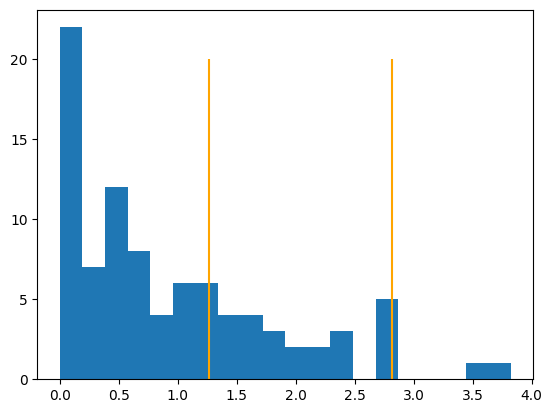

In [19]:
alphas = [0.05, 0.32]
# Setting method='higher' is a nuance here to ensure we actually get the same quantiles as MAPIE's implementation later on
quantiles = [np.nanquantile(scores, 1.0-alpha, method='higher') for alpha in alphas]
plt.hist(scores, bins=20)
plt.vlines(quantiles, ymin=0, ymax=20, color='orange')
plt.show()

Let's upscale the prediction bands using the obtained quantiles! All we need to do is to pre-multiply the residual error estimates by the quantiles for the respective target coverage $(1-\alpha)$.

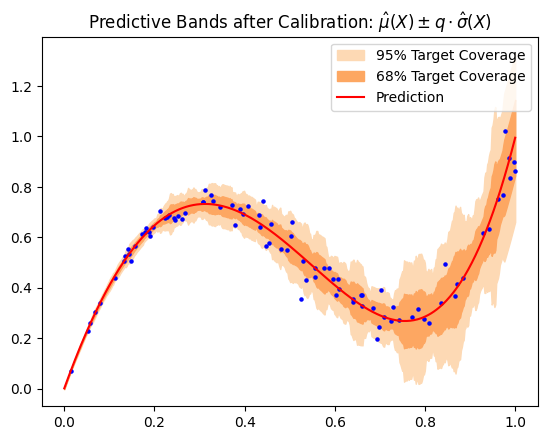

In [22]:
mean_prediction = mean_predictor.predict(X)
residual_prediction = residual_predictor.predict(X)
prediction_bounds = construct_prediction_bounds(mean_prediction, residual_prediction, quantiles)

fig, ax = plt.subplots(1, 1)
regression_plot_with_uncertainty(
    ax,
    X,
    mean_prediction,
    prediction_bounds,
    (X_cal, y_cal),
    quantiles=quantiles,
    labels=['95% Target Coverage', '68% Target Coverage']
)
ax.set_title(r'Predictive Bands after Calibration: $\hat{\mu}(X) \pm q \cdot \hat{\sigma}(X)$')
plt.show()

This looks much better! Per design, we should have roughly ($1-\alpha$) coverage on the calibration and test sets. Let's double check!

In [23]:
def compute_coverage(y, prediction_bounds):
    num_points_outside = np.sum((y < prediction_bounds[:,0]) | (y > prediction_bounds[:,1]))
    coverage_score = 1.0-num_points_outside/len(y)
    return coverage_score

In [24]:
cal_prediction_bounds = construct_prediction_bounds(cal_mean_prediction, cal_residual_prediction, quantiles)
test_mean_prediction = mean_predictor.predict(X_test)
test_residual_prediction = residual_predictor.predict(X_test)
test_prediction_bounds = construct_prediction_bounds(test_mean_prediction, test_residual_prediction, quantiles)

for i, alpha, q in zip(list(range(len(quantiles))), alphas, quantiles):
    print()
    print(f'Alpha: {alpha} (Target coverage: {(1.0-alpha)*100:.2f}%)')
    print('-'*50)
    coverage = compute_coverage(y_cal, cal_prediction_bounds[:,:,i])
    print(f"Actual coverage on the calibration set: {coverage * 100:.2f}%")
    coverage = compute_coverage(y_test, test_prediction_bounds[:,:,i])
    print(f"Actual coverage on the test set: {coverage * 100:.2f}%")


Alpha: 0.05 (Target coverage: 95.00%)
--------------------------------------------------
Actual coverage on the calibration set: 95.56%
Actual coverage on the test set: 96.00%

Alpha: 0.32 (Target coverage: 68.00%)
--------------------------------------------------
Actual coverage on the calibration set: 68.89%
Actual coverage on the test set: 76.00%


## Comparison against MAPIE

Finally, we want to double check whether our implementation matches the one from MAPIE.

In [27]:
# MAPIE code to fit the same model

from mapie.regression import MapieRegressor
from mapie.conformity_scores import ResidualNormalisedScore

# By default conformity_score=None => AbsoluteConformityScore is used
# We choose mapie.conformity_scores.ResidualNormalisedScore instead
# See here for a documentation: https://mapie.readthedocs.io/en/latest/theoretical_description_conformity_scores.html
conformity_score = ResidualNormalisedScore(residual_estimator=residual_predictor, prefit=True)
mapie_regressor = MapieRegressor(mean_predictor, conformity_score=conformity_score, cv='prefit', method='base')
mapie_regressor.fit(X_cal, y_cal)
y_pred, y_pis = mapie_regressor.predict(X, alpha=alphas)

Let's start by verifying whether our manually computed prediction bounds are indeed equal up to $\epsilon$.

In [28]:
epsilon = 1e-12
proportion_equal_vals = np.mean( np.abs(y_pis-prediction_bounds) < epsilon )
print(f'{proportion_equal_vals*100:.2f}% of values are equal.')

100.00% of values are equal.


That looks good! Our implementation seems to be correct!

For completeness, let's also confirm that we obtain the same plot as before. For a clearer comparison, we put them side by side. This time we plot the test points instead of the calibration points.

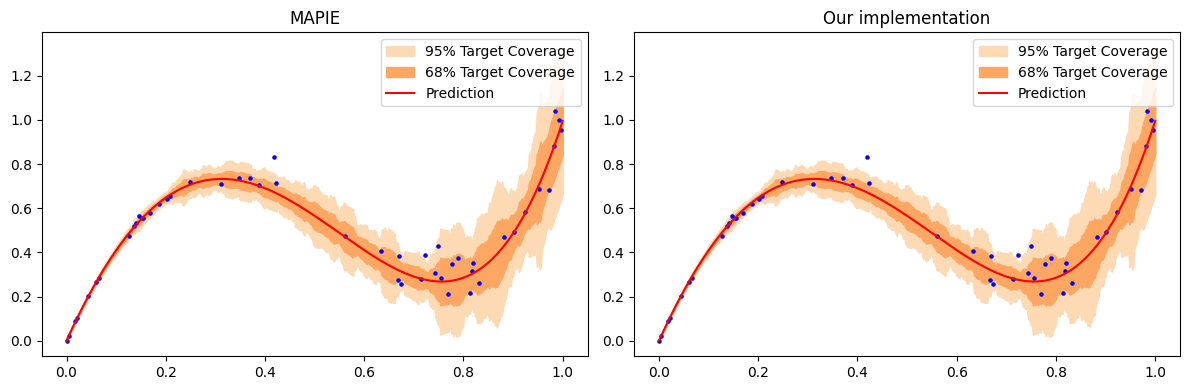

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
regression_plot_with_uncertainty(
    ax[0],
    X,
    y_pred,
    y_pis,
    (X_test, y_test),
    quantiles=quantiles,
    labels=['95% Target Coverage', '68% Target Coverage']
)

regression_plot_with_uncertainty(
    ax[1],
    X,
    mean_prediction,
    prediction_bounds,
    (X_test, y_test),
    quantiles=quantiles,
    labels=['95% Target Coverage', '68% Target Coverage']
)

ax[0].set_title('MAPIE')
ax[1].set_title('Our implementation')
plt.tight_layout()
plt.show()